# Faiss KNN imputation example and scikit-learn comparison

[Faiss](https://github.com/facebookresearch/faiss) is a library for efficient similarity search and clustering of dense vectors.
The FaissImputer makes use of faiss to efficiently search nearest neighbors for dense matrices.

## Prediction performance comparison

In [1]:
import numpy as np
import pandas as pd
from fknni import FaissImputer
from sklearn.impute import KNNImputer

In [2]:
rng = np.random.default_rng(0)

# Create a DataFrame with 10 missing values
df = pd.DataFrame(rng.integers(0, 100, size=(10, 5)), columns=list("ABCDE"))
df

,A,B,C,D,E
0,85,63,51,26,30
1,4,7,1,17,81
2,64,91,50,60,97
3,72,63,54,55,93
4,27,81,67,0,39
5,85,55,3,76,72
6,84,17,8,86,2
7,54,8,29,48,42
8,40,2,0,12,0
9,67,52,64,25,61


In [3]:
df_missing = df.copy()
indices = [(i, j) for i in range(df.shape[0]) for j in range(df.shape[1])]
rng.shuffle(indices)
for i, j in indices[:10]:
    df_missing.iat[i, j] = np.nan
df_missing

,A,B,C,D,E
0,85.0,63.0,51.0,26.0,30.0
1,NaN,7.0,NaN,17.0,NaN
2,64.0,NaN,50.0,60.0,NaN
3,72.0,63.0,54.0,55.0,NaN
4,NaN,81.0,67.0,0.0,39.0
5,85.0,55.0,3.0,76.0,72.0
6,84.0,17.0,8.0,86.0,2.0
7,54.0,NaN,29.0,48.0,42.0
8,NaN,2.0,0.0,12.0,0.0
9,67.0,52.0,64.0,NaN,61.0


In [4]:
faiss_imputer = FaissImputer(n_neighbors=5, strategy="weighted")

df_imputed_faiss = faiss_imputer.fit_transform(df_missing)
df_imputed_faiss

array([[85.      , 63.      , 51.      , 26.      , 30.      ],
       [84.73166 ,  7.      , 28.905973, 17.      , 31.722939],
       [64.      , 50.318653, 50.      , 60.      , 33.64209 ],
       [72.      , 63.      , 54.      , 55.      , 33.550114],
       [84.926   , 81.      , 67.      ,  0.      , 39.      ],
       [85.      , 55.      ,  3.      , 76.      , 72.      ],
       [84.      , 17.      ,  8.      , 86.      ,  2.      ],
       [54.      , 50.110676, 29.      , 48.      , 42.      ],
       [84.55753 ,  2.      ,  0.      , 12.      ,  0.      ],
       [67.      , 52.      , 64.      , 44.489838, 61.      ]],
      dtype=float32)

In [5]:
imputer = KNNImputer(n_neighbors=5)

In [ ]:
df_imputed_scikit = imputer.fit_transform(df_missing)
df_imputed_scikit

array([[85. , 63. , 51. , 26. , 30. ],
       [68.4,  7. , 38.8, 17. , 27. ],
       [64. , 50. , 50. , 60. , 41.4],
       [72. , 63. , 54. , 55. , 48.8],
       [68.4, 81. , 67. ,  0. , 39. ],
       [85. , 55. ,  3. , 76. , 72. ],
       [84. , 17. ,  8. , 86. ,  2. ],
       [54. , 48. , 29. , 48. , 42. ],
       [71.8,  2. ,  0. , 12. ,  0. ],
       [67. , 52. , 64. , 37.8, 61. ]])

In [7]:
mse = np.mean((df_imputed_scikit - df_imputed_faiss) ** 2)
mae = np.mean(np.abs(df_imputed_scikit - df_imputed_faiss))

print(f"Mean Absolute Error between scikit-learn and faiss: {mae}")

Mean Absolute Error between scikit-learn and faiss: 1.8471824569702144


In [8]:
mse = np.mean((df - df_imputed_faiss) ** 2)
mae = np.mean(np.abs(df - df_imputed_faiss))

print(f"Mean Absolute Error between original DataFrame and faiss: {mae}")

Mean Absolute Error between original DataFrame and faiss: 9.70975772857666


In [9]:
mse = np.mean((df - df_imputed_scikit) ** 2)
mae = np.mean(np.abs(df - df_imputed_scikit))

print(f"Mean Absolute Error between original DataFrame and scikit-learn: {mae}")

Mean Absolute Error between original DataFrame and scikit-learn: 8.46


## Speed comparison

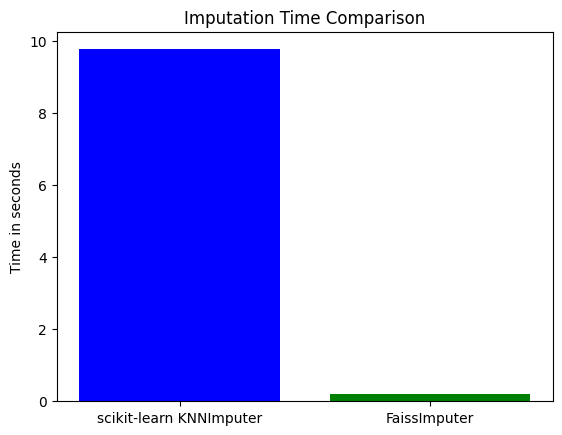

In [10]:
import time
import matplotlib.pyplot as plt
from sklearn.datasets import make_classification

n_samples, n_features = 10000, 50
X, _ = make_classification(n_samples=n_samples, n_features=n_features, random_state=42)
X = pd.DataFrame(X)
n_missing = int(n_samples * n_features * 0.1)
missing_indices = np.random.choice(X.size, n_missing, replace=False)
X.values[np.unravel_index(missing_indices, X.shape)] = np.nan

knn_imputer = KNNImputer(n_neighbors=5)
faiss_imputer = FaissImputer(n_neighbors=5)

start_time = time.time()
knn_imputed = knn_imputer.fit_transform(X)
knn_time = time.time() - start_time

start_time = time.time()
faiss_imputed = faiss_imputer.fit_transform(X)
faiss_time = time.time() - start_time

times = [knn_time, faiss_time]
labels = ["scikit-learn KNNImputer", "FaissImputer"]
plt.bar(labels, times, color=["blue", "green"])
plt.ylabel("Time in seconds")
plt.title("Imputation Time Comparison")
plt.show()